In [ ]:
'''
Sentiment Analysis performed on IMDB Dataset of Movie Reviews using Pytorch And TorchText

'''
#Importing Necessary Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import collections
from torchtext import data
from torchtext import datasets


In [ ]:
#Defining Fields for Text Data
TEXT = data.Field(tokenize = 'spacy',include_lengths=True)  #Tokenize using spacy and Include Text Lengths
LABEL = data.LabelField(dtype = torch.float) # Define Datatype of Label as Float as Sentiment is either 0 or 1

In [ ]:
#Loading DataSet from TorchText into Train and Test Data
train_data,test_data=datasets.IMDB.splits(TEXT,LABEL)

In [ ]:
#Split the TrainData into 70% Train and 30 % Validation Data 
train_data,val_data= train_data.split(random_state=random.seed(1010))

In [ ]:
#A Look through Dataset
print(vars(train_data.examples[0]))
print(vars(val_data.examples[0]))
print(vars(test_data.examples[0]))

{'text': ['This', 'is', 'exactly', 'the', 'reason', 'why', 'many', 'people', 'remain', 'homeless', '.', '.', '.', 'because', 'stupid', 'producers', 'pay', 'their', 'money', 'to', 'make', 'awful', 'films', 'like', 'this', 'instead', 'of', 'donating', 'if', 'they', 'can', 'bother!<br', '/><br', '/>This', 'film', 'is', 'even', 'worse', 'than', 'white', 'chicks', '!', 'Little', 'Man', 'has', 'a', 'lame', 'excuse', 'for', 'posing', 'a', 'character', 'midget', 'as', 'a', 'baby', '.', 'Story', 'is', 'awful', 'considering', 'it', 'was', 'written', 'by', 'six', 'people', '.', 'The', 'idea', 'still', 'would', "n't", 'be', 'too', 'bad', 'though', ',', 'if', 'it', 'was', 'original', 'and', 'not', 'a', 'rip', '-', 'off', 'of', 'a', 'cartoon', 'episode', '.', 'it', 'has', 'funny', 'moments', 'but', 'some', 'of', 'them', 'are', 'way', 'over', '-', 'done', 'and', 'some', 'are', 'just', 'stupid', '.', 'The', 'acting', 'was', 'very', ',', 'very', 'bad', '.', 'So', 'was', 'the', 'directing', '.', 'Anyone

In [ ]:
#Printing The Size of Dataset
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [ ]:
'''
Text Preprocessing

1.Tokenization
2.Building of Vocabulary
3.Encode the Dataset using GloVe Representation
4.Padding the Sequence to a Maximum Length

'''
TEXT.build_vocab(train_data,max_size=25000,vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)  
LABEL.build_vocab(train_data)

In [ ]:

print('Number of Unique Token in the Vocabulary :',len(TEXT.vocab))

print('Number of Unique Token In Label: ',len(LABEL.vocab))

print('Most Frequent Tokens in Vocabulary',TEXT.vocab.freqs.most_common(10))

Number of Unique Token in the Vocabulary : 25002
Number of Unique Token In Label:  2
Most Frequent Tokens in Vocabulary [('the', 201444), (',', 191662), ('.', 165225), ('and', 109346), ('a', 109052), ('of', 100051), ('to', 92982), ('is', 76331), ('in', 60999), ('I', 53879)]


In [ ]:
print(TEXT.vocab.stoi)
print(LABEL.vocab.itos)

defaultdict(<function _default_unk_index at 0x7f8731650f28>, {'<unk>': 0, '<pad>': 1, 'the': 2, ',': 3, '.': 4, 'and': 5, 'a': 6, 'of': 7, 'to': 8, 'is': 9, 'in': 10, 'I': 11, 'it': 12, 'that': 13, '"': 14, "'s": 15, 'this': 16, '-': 17, '/><br': 18, 'was': 19, 'as': 20, 'with': 21, 'movie': 22, 'for': 23, 'film': 24, 'The': 25, 'but': 26, '(': 27, 'on': 28, "n't": 29, ')': 30, 'you': 31, 'are': 32, 'not': 33, 'have': 34, 'his': 35, 'be': 36, 'he': 37, 'one': 38, '!': 39, 'at': 40, 'all': 41, 'by': 42, 'who': 43, 'an': 44, 'from': 45, 'like': 46, 'they': 47, 'so': 48, 'her': 49, "'": 50, 'about': 51, 'has': 52, 'or': 53, 'It': 54, 'out': 55, 'just': 56, 'do': 57, '?': 58, 'some': 59, 'good': 60, 'more': 61, 'very': 62, 'would': 63, 'up': 64, 'what': 65, 'This': 66, 'there': 67, 'time': 68, 'can': 69, 'which': 70, 'when': 71, 'she': 72, 'story': 73, 'only': 74, 'had': 75, 'really': 76, 'if': 77, 'see': 78, 'were': 79, 'their': 80, 'even': 81, 'no': 82, 'my': 83, 'does': 84, 'did': 85, '

In [ ]:
#Defining Batch_size and Device
BATCH_SIZE=64

device=torch.device(('cuda' if torch.cuda.is_available() else 'CPU' ))
print(device)

cuda


In [ ]:
#DataIterator for placing Tensors in GPU
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch=True,
    device = device)

In [ ]:
# Define the Network for Sentiment Analysis

class Network(nn.Module):
  def __init__(self,vocab_size,embbed_dim,hidden_dim,output_dim,pad_idx):
    super().__init__()
    self.input_dim=vocab_size
    self.hidden_dim=hidden_dim
    self.embbed_dim=embbed_dim
    self.output_dim=output_dim
    self.Embedding=nn.Embedding(self.input_dim,self.embbed_dim,padding_idx=pad_idx)
    self.rnn=nn.LSTM(self.embbed_dim,self.hidden_dim,2,bidirectional=True,dropout=0.5)
    self.FC=nn.Linear(2*hidden_dim,output_dim)
    self.dropout=nn.Dropout(0.5)
  def forward(self,text,text_lengths):
    
    #text = [sent len, batch size]
        
    embedded = self.Embedding(text)
        
    #embedded = [sent len, batch size, emb dim]
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)  #Packed Padded Sequences for Training The Network
        
    packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
    #unpack sequence
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

    #output = [sent len, batch size, hid dim * num directions]
    #output over padding tokens are zero tensors
    #hidden = [num layers * num directions, batch size, hid dim]
    #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
    #and apply dropout
        
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
    return self.FC(hidden)


In [ ]:

#Parameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
pad_idx=TEXT.vocab.stoi[TEXT.pad_token] 

#Initialize Network
model = Network(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pad_idx).to(device)

#Here We use Adam Optimizer and Binary Cross Entropy with Logits Loss
optimizer=optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.BCEWithLogitsLoss().cuda()

In [ ]:
#Loading the Pretrained  embedding and Copy the Embedding Matrix into Embedding Layer Weights
pretrained_embeddings = TEXT.vocab.vectors
model.Embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

#For <unk> and <pad> we Initialize Initial Weight data in Embedding as Zero
model.Embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.Embedding.weight.data[pad_idx] = torch.zeros(EMBEDDING_DIM)

print(model.Embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.5997,  0.5478, -0.3513,  ..., -0.1591, -0.1539,  0.5652],
        [ 0.4906, -0.5260, -0.4986,  ...,  0.2390,  0.6330,  0.0374],
        [ 0.1823,  0.2115,  0.3303,  ...,  0.1079, -0.3008,  0.5418]],
       device='cuda:0')


In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#Function To Train the Model
def train(model,optimizer,criterion,Data):
  epoch_loss = 0
  epoch_acc = 0
    
  model.train()
    
  for batch in Data:
        
      optimizer.zero_grad()
      text,text_length=batch.text
      predictions = model(text,text_length).squeeze(1)
      loss = criterion(predictions, batch.label)
      acc = binary_accuracy(predictions, batch.label)
      loss.backward()
      optimizer.step() 
      epoch_loss += loss.item()
      epoch_acc += acc.item()
        
  return epoch_loss / len(Data), epoch_acc / len(Data)

In [ ]:
# Function to Evaluate the Model 

def evaluate(model,criterion,Data):
  val_loss=0
  val_acc=0
  model.eval()
  with torch.no_grad():
    for batch in Data:
      text,text_length=batch.text
      predictions=model(text,text_length).squeeze(1)
      loss = criterion(predictions, batch.label)
      acc = binary_accuracy(predictions, batch.label)
      val_loss += loss.item()
      val_acc += acc.item()    
  return val_loss / len(Data), val_acc / len(Data)

In [ ]:
num_epoch=5
vali_loss=[]
train_loss=[]

# Training the Network
for epoch in range(num_epoch):

  epoch_loss,epoch_acc=train(model,optimizer,criterion,train_iterator)
  val_loss,val_acc=evaluate(model,criterion,valid_iterator)
  train_loss.append(epoch_loss)
  vali_loss.append(val_loss)
  print("\tTrain Loss: %0.3f  Train Acc: %.2f"%(epoch_loss,epoch_acc))
  print("\t Val. Loss: %.3f  Val. Acc: %.2f"%(val_loss,val_acc))


  


	Train Loss: 0.695  Train Acc: 0.53
	 Val. Loss: 0.686  Val. Acc: 0.55
	Train Loss: 0.577  Train Acc: 0.68
	 Val. Loss: 0.380  Val. Acc: 0.84
	Train Loss: 0.340  Train Acc: 0.86
	 Val. Loss: 0.321  Val. Acc: 0.87
	Train Loss: 0.243  Train Acc: 0.91
	 Val. Loss: 0.350  Val. Acc: 0.86
	Train Loss: 0.196  Train Acc: 0.93
	 Val. Loss: 0.321  Val. Acc: 0.89


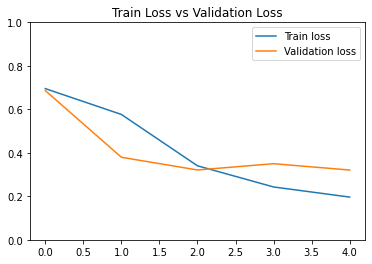

In [ ]:
#Visualizing Train vs Validation Loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Train Loss vs Validation Loss')
plt.ylim(0,1)
plt.plot(train_loss)
plt.plot(vali_loss)
plt.legend(['Train loss','Validation loss'])
plt.show()


In [ ]:
# Testing the Model using Test Dataset and We get 87% Accuracy
test_loss, test_acc = evaluate(model, criterion,test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.351 | Test Acc: 86.91%
